**Kaggle**

Arrhythmia Dataset
Number of Samples: 109446  
Number of Categories: 5  
Sampling Frequency: 125Hz  
**Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]**   
Data Source: Physionet's MIT-BIH Arrhythmia Dataset  

The PTB Diagnostic ECG Database  
Number of Samples: 14552  
Number of Categories: 2  
**Classes: ['0': N (Normal), '1': ['S', 'V', 'F', 'Q'] (Abnormal)]**      
Sampling Frequency: 125Hz  
Data Source: Physionet's PTB Diagnostic Database

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.  

In [1]:
# from google.colab import files
# files.upload()   # Upload your kaggle.json here

# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d shayanfazeli/heartbeat

# !unzip heartbeat.zip -d ecg_data

**Lets Begin**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

from utils.data import *

In [3]:
mitbih_train_val_df = pd.read_csv("data/mitbih_train.csv", header=None)
mitbih_test_df = pd.read_csv("data/mitbih_test.csv", header=None)
print(f"MitBih (Train + Val) Df shape: {mitbih_train_val_df.shape}")
print(f"MitBih Test Df shape: {mitbih_test_df.shape}")

print("-----------------------------------------")

ptb_normal_df = pd.read_csv("data/ptbdb_normal.csv", header=None)
ptb_abnormal_df = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
print(f"Ptb Normal Df shape: {ptb_normal_df.shape}")
print(f"Ptb AbNormal Df shape: {ptb_abnormal_df.shape}")


MitBih (Train + Val) Df shape: (87554, 188)
MitBih Test Df shape: (21892, 188)
-----------------------------------------
Ptb Normal Df shape: (4046, 188)
Ptb AbNormal Df shape: (10506, 188)


In [4]:
class_map = {
    "0": "N", 
    "1": "S",
    "2": "V",
    "3": "F",
    "4": "Q"
}

In the MIT Dataset we have distinct Classes  
Class 1: N --> Normal Beat   
Class 2: S --> Supraventricular Ectopy  
Class 3: V --> Ventricular Ectopy  
Class 4: F --> Fusion Beat  
Class 5: Q --> Unknown Beat  
      
However the PTB Dataset is a bit more ambiguous. 
Class 0 (Normal) will remain as it is. Class 0 (N)  
Class 1 (Abnormal) will be mapped to Class 4 (Q: Unknown)

In [5]:
# Mapping Classes Accordingly
ptb_normal_df.iloc[:, -1] = 0
ptb_abnormal_df.iloc[:, -1] = 4

-- Now we combine all the Datasets (MIT + PTB)

In [6]:
# combine ptb datasets
ptb_combined_df = pd.concat([ptb_normal_df, ptb_abnormal_df], ignore_index=True, axis=0)
print(f"Ptb Combined Df shape: {ptb_combined_df.shape}")

print("-------------------------------------------")

# combine ptb and mit datasets 
# this will form the new (Train + Val) dataset
combined_train_val_df = pd.concat([mitbih_train_val_df, ptb_combined_df], ignore_index=True, axis=0)
print(f"Combined Df (Train + Val) shape: {combined_train_val_df.shape}")

Ptb Combined Df shape: (14552, 188)
-------------------------------------------
Combined Df (Train + Val) shape: (102106, 188)


In [7]:
combined_train_val_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-- Separate Features (X) and Labels (y)

In [8]:
X, y = split_x_y(combined_train_val_df) # (Train + Val)
X_test, y_test = split_x_y(mitbih_test_df) # (Test)

-- Plot Class Distribution

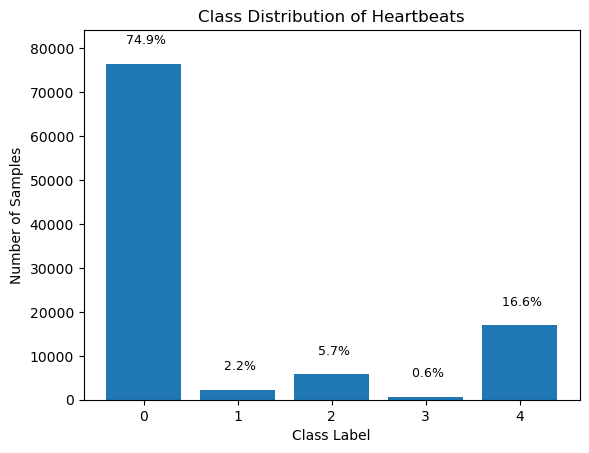

In [9]:
plot_class_distributions(y=y, 
                         title="Class Distribution of Heartbeats",
                         xlabel="Class Label",
                         ylabel="Number of Samples",)

-- Creating our Train Val Split  

We notice that there is a significant imbalance in classes  
Hence we will use a stratified split

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X,y,
    test_size= 0.2,
    random_state= 42,
    stratify= y # ensures equal class representation
)

-- Plotting Samples from each Class before Normalisation

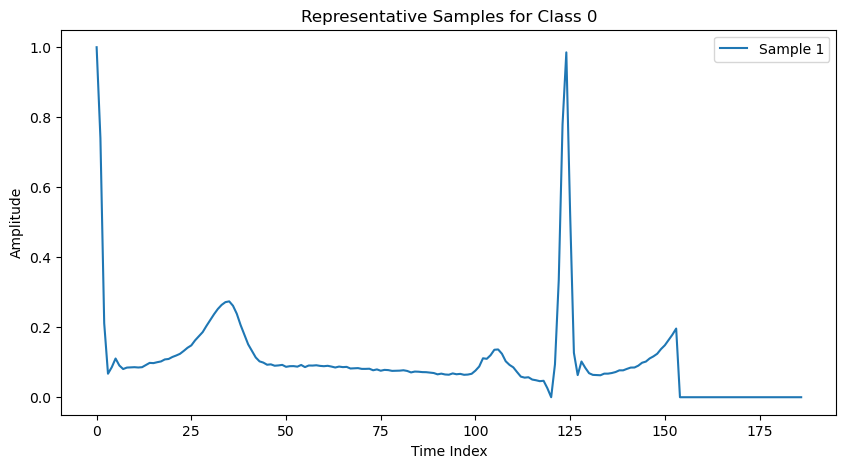

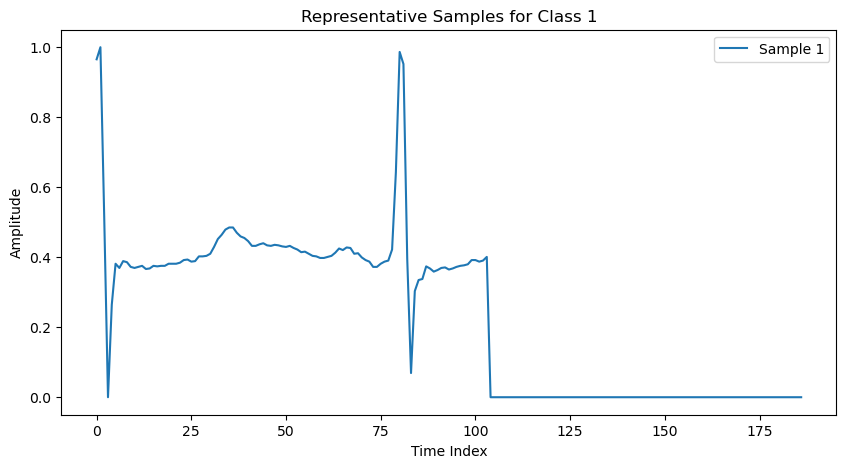

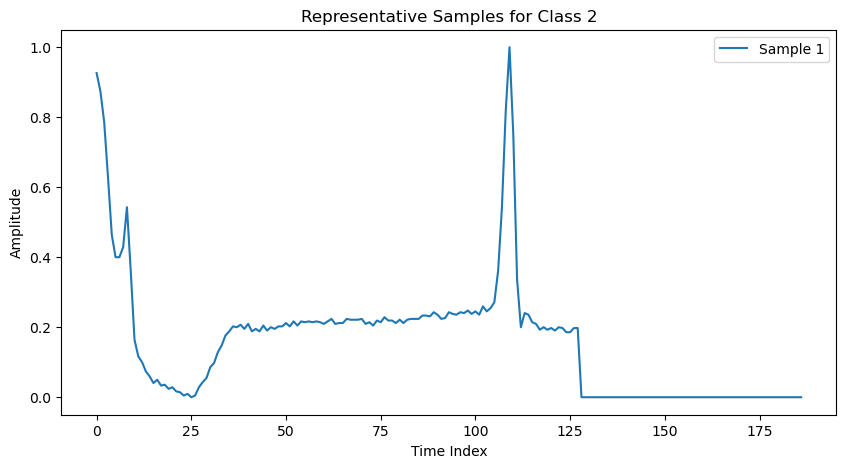

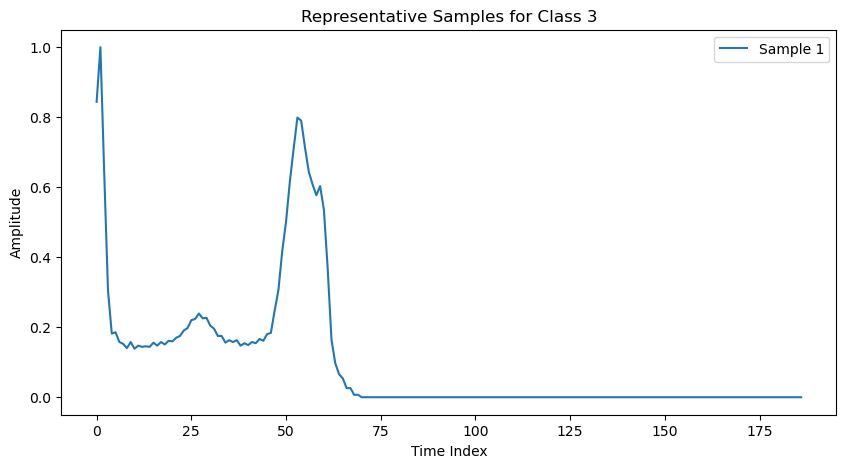

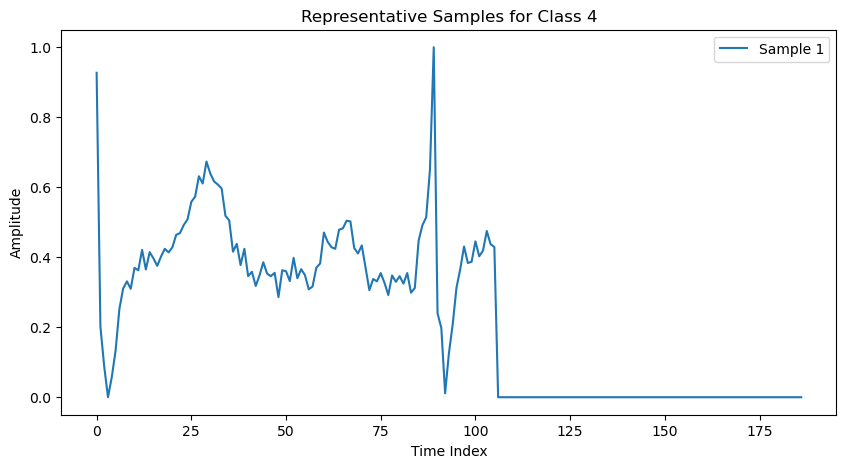

In [21]:
plot_unique_class_samples(X_train,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(10,5))

**Data Preprocessing**

In [12]:
from utils.preprocessing import get_r_peak_locations
import seaborn as sns
import numpy as np


c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# We just need a small sample because it will result in a mean close enough to the actual mean
X_train_sample = sample(X_train, sample_size_fraction= 0.01, random_state= 42)

print(f"Sampling {len(X_train_sample)} of {len(X_train)} samples")
print("--------------------------------------------")

r_peak_indices = get_r_peak_locations(X=X_train_sample, sampling_rate=125)

print(f"Mean R_Peak Index: {np.round(np.mean(r_peak_indices).item())}")

Sampling 817 of 81684 samples
--------------------------------------------


Mean R_Peak Index: 42.0


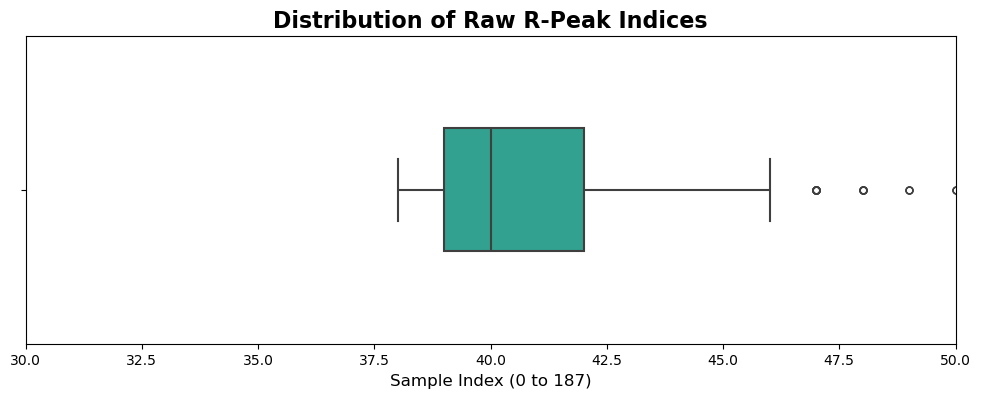

In [14]:
LOWER_LIMIT = 30
UPPER_LIMIT = 50 

plt.figure(figsize=(12, 4)) 

sns.boxplot(
    x=r_peak_indices, 
    color="#1fb49b", 
    width=0.4,        
    linewidth=1.5,     
    fliersize=5        
)

plt.xlim(LOWER_LIMIT, UPPER_LIMIT)

plt.title('Distribution of Raw R-Peak Indices', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index (0 to 187)', fontsize=12)

plt.show()

It looks like the raw data is biased to have a peak around index 42  

However for this experiment we will be **shifing the R-peaks to Index 94 (187 / 2)**
  
Reason:  
  1) The primary reason for shifting the R-peaks from the observed raw mean of $\approx 42$ to the symmetrical center of Index 94 is to achieve optimal temporal symmetry for deep learning model stability and feature extraction.

  2) Maximizing Informative Features:   
    Initially we had 41 sequence samples consisting of P,Q waves (Before R). and 147 sequence samples consisting of the S,T waves (After R) and padded 0s. As you can see, the model has less time steps(for RNNs) / less samples to learn about P,Q waves (41 time steps).  

    By shifting the R to 94, we have more balanced feature set (94 samples before and 93 samples after), and so the model has more context (time steps / samples) to learn the pattern of both the P Q and S, T waves effectively, leading to a faster convergence and higher accuracy 

 

In [15]:
from utils.preprocessing import linear_alignment_of_r_peaks

In [16]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.740180,0.211323,0.067149,0.085802,0.110599,0.090630,0.080535,0.084705,0.085363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.926991,0.201327,0.087758,0.000000,0.057522,0.132743,0.251475,0.310472,0.331121,0.309735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.858612,0.231362,0.007712,0.064267,0.074550,0.066838,0.053985,0.066838,0.056555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.979762,0.870238,0.416667,0.000000,0.180952,0.201190,0.138095,0.134524,0.141667,0.144048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.914692,0.639810,0.417062,0.189573,0.071090,0.000000,0.075829,0.113744,0.180095,0.175355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_train = linear_alignment_of_r_peaks(X_train,
                                      sampling_rate=125,
                                      target_index=94,
                                      method="pantompkins")

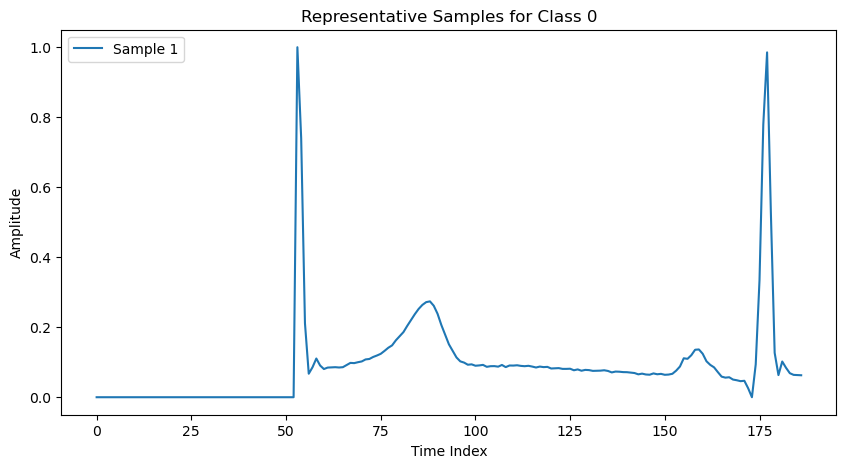

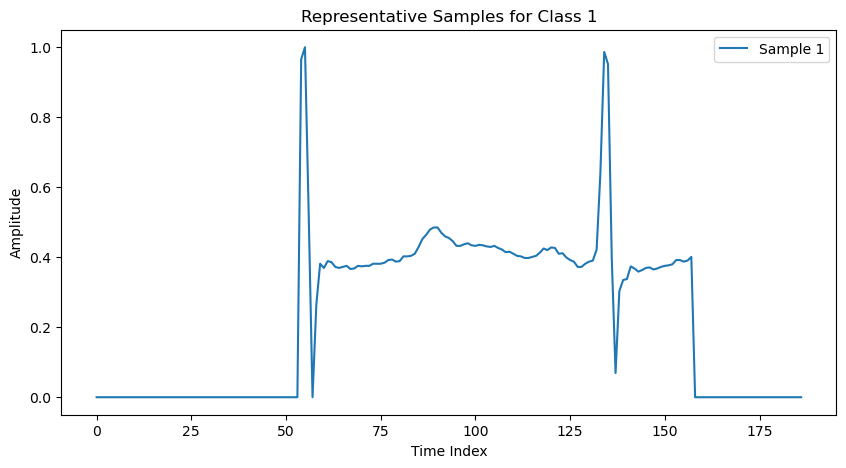

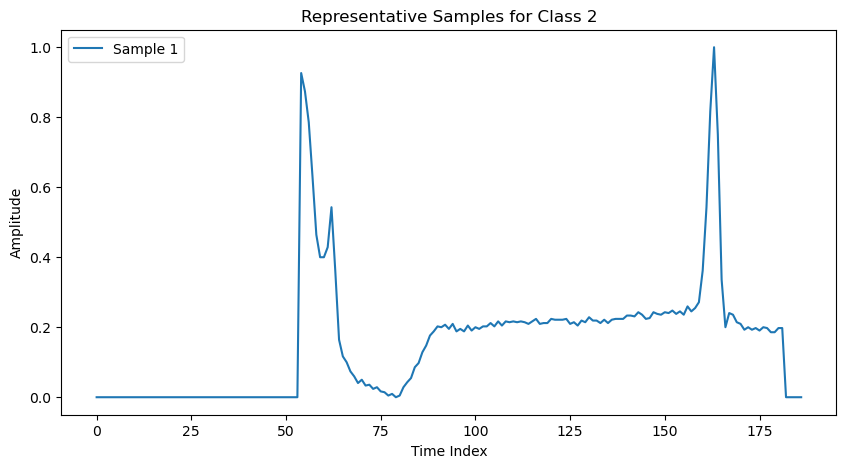

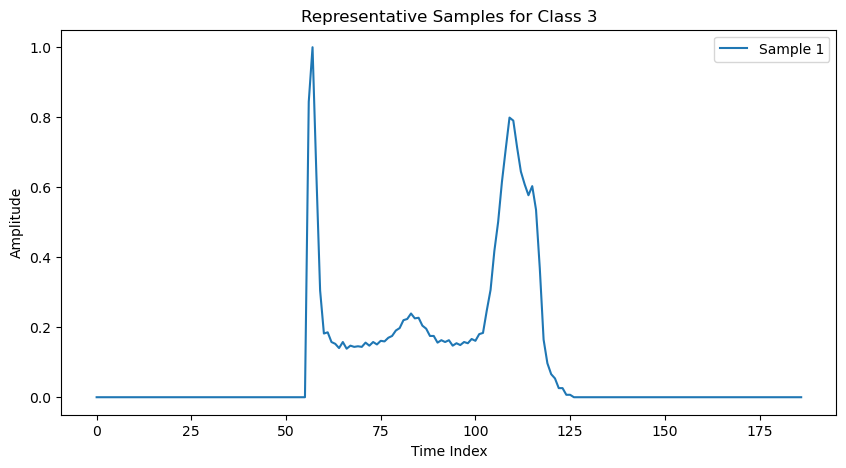

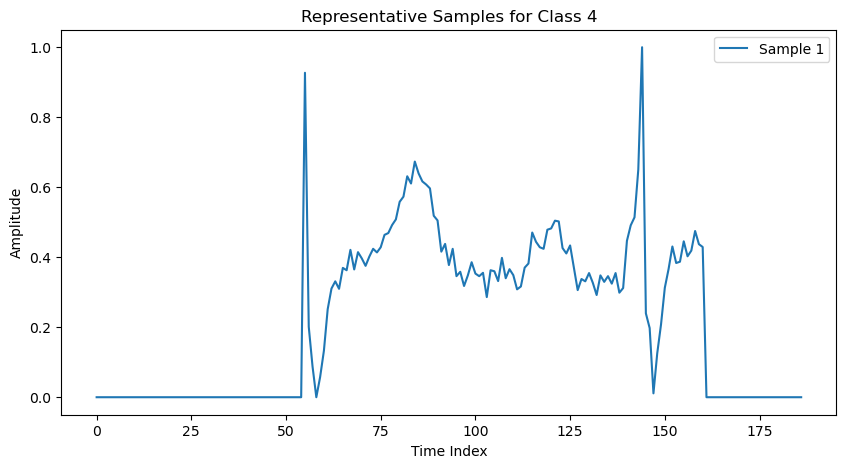

In [18]:
plot_unique_class_samples(X_train,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(10,5))